# Introduction to JOLI

[JOLI](https://github.com/slimgroup/JOLI.jl) is a Julia framework for constructing matrix-free linear operators with explicit domain/range type control and applying them in basic algebraic matrix-vector operations. This notebook mainly covers 3 things:

1. How to build a linear operator in JOLI, and verify its correctness.
2. How to solve a linear inverse problem $Ax=b$ where $A$ is a linear operator defined by JOLI.
3. How JOLI interacts with machine learning toolbox in Julia (Flux) via ChainRules.

## Build a linear operator

We start by loading a few packages.

In [1]:
using LinearAlgebra, FFTW, JOLI, JOLI4Flux, PyPlot, Random, IterativeSolvers, GenSPGL, Test;
using JOLI4Flux, Optim, Zygote, ChainRulesCore, Flux;
Random.seed!(4321);

The JOLI toolbox gives a way to represent matrices implicitly. Instead of storing all entries in a matrix, JOLI only needs to store the forward and adjoint actions of this matrix on a vector, and the metadata (domain/range types etc).

For example, we can construct a convolution operator given its kernel $w$. We know that the forward action of the convolution and adjoint action of the convolution (cross-correlation) can be computed easily thanks to Fourier transform---i.e.,

$$\mathcal{F}(w\ast x) = \mathcal{F}(w)\cdot \mathcal{F}(x),$$

and

$$\mathcal{F}(w\star x) = \overline{\mathcal{F}(w)}\cdot \mathcal{F}(x),$$

where $\mathcal{F}$ denotes the Fourier transform, $x$ is a signal (e.g. vector in 1D), $\overline{\cdot}$ denotes conjugation, and $\ast$ and $\star$ denotes convolution and cross-correlation respectively. The convolution and cross-correlation can be defined in Julia as

In [2]:
conv(w, x) = real.(ifft(fft(w).*fft(x)));
crosscorr(w, x) = real.(ifft(conj(fft(w)).*fft(x)));

Then, we can construct a JOLI operator `A` to represent the convolution operator with kernel `w`.

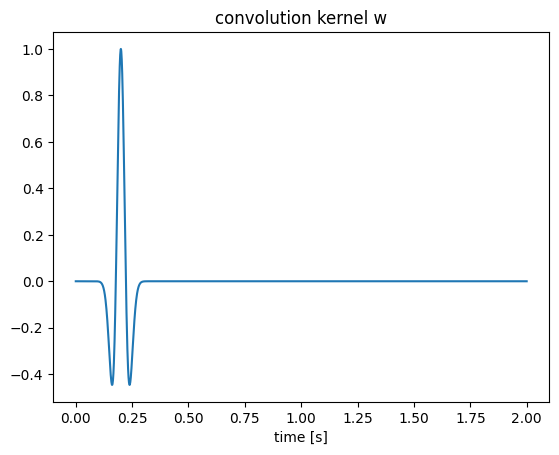

In [3]:
t = 0:.001:2';   # time interval
N = length(t);   # length
w = (1 .-2*1e3*(t .-.2).^2).*exp.(-1e3*(t .-.2).^2);    # convolution kernel
A = joLinearFunctionFwd(N, N,  # input and output size
        x -> conv(w, x),        # how to compute A*x
        x -> crosscorr(w, x),        # how to compute transpose(A)*x
        x -> crosscorr(w, x),        # how to compute adjoint(A)*x
        x -> conv(w, x),        # how to compute conj(A)*x
        Float64, Float64; name="ConvOp");        # domain and range types, operator name
figure();plot(t, w);title("convolution kernel w");xlabel("time [s]");

We can access the types of domain/range and size of `A` via native julia functions

In [4]:
println("size(A) is ", size(A))
println("domain type is ", deltype(A))
println("range type is ", reltype(A))

size(A) is (2001, 2001)
domain type is Float64
range type is Float64


After we define the linear operator `A`, we should verify its correctness by linearity test and adjoint test

In [5]:
x1 = randn(N);
x2 = randn(N);
@test isapprox(A * x1 + A * x2, A * (x1 + x2));        # linearity test
@test isapprox(dot(x1, A * x2), dot(A' * x1, x2));     # adjoint(dot) test

In [6]:
println("linearity test, ", islinear(A)[1])
println("adjoint test, ", isadjoint(A)[1])

linearity test, true
adjoint test, true


## Solve $Ax=b$ with the built linear operator

Now we have successfully defined a linear operator `A` with JOLI toolbox. We can then solve a linear inverse problem

$$Ax=b$$

using julia native toolbox, such as iterative solvers. In this tutorial, we set up a ground truth `x` as a sparse vector, and use 2 iterative methods to solve for `x`---LSQR and spgl1. Notice that these iterative methods only require the forward and adjoint evaluations of `A`, which are both provided by our JOLI operator. Thanks to the power of abstraction in Julia, we do not need to overload these iterative algorithms. Things work out of the box.

Paige, Christopher C., and Michael A. Saunders. "LSQR: An algorithm for sparse linear equations and sparse least squares." ACM Transactions on Mathematical Software (TOMS) 8.1 (1982): 43-71.
spgl1

E. van den Berg and M. P. Friedlander, Probing the Pareto frontier for basis pursuit solutions, SIAM J. on Scientific Computing, 31(2):890-912, November 2008.

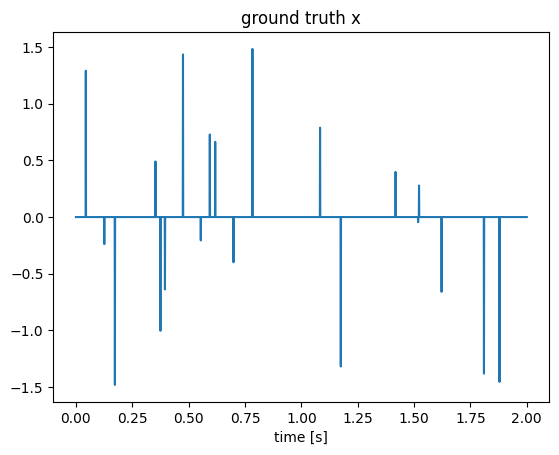

In [7]:
k = 20;
x = zeros(N);
x[rand(1:N, k)] = randn(k);
figure();plot(t, x);title("ground truth x");xlabel("time [s]");

We then generate a noisy measurement `b` via perturbing the forward evaluation by a noise term `e`.

In [8]:
e = 1e-5 * randn(N);    # noise
b = A * x + e;          # noisy measurement

Then we can first solve for `x` using LSQR in IterativeSolvers.jl package

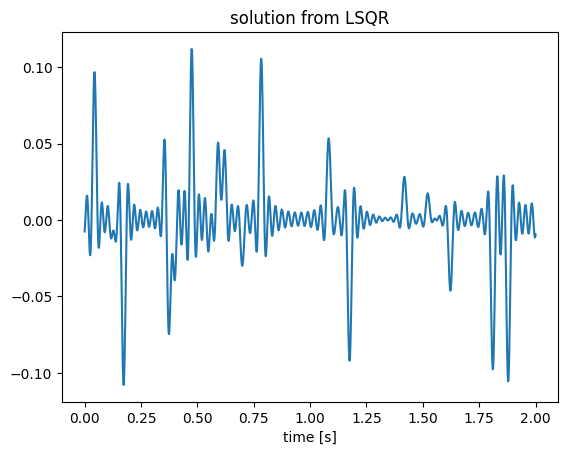

In [9]:
x1 = lsqr(A, b; maxiter=500);
figure();plot(t, x1);title("solution from LSQR");xlabel("time [s]");

We can see the recovery is somehow noisy because the convolution operator has a null space. Since the ground truth signal is sparse, we can use spgl1 algorithm to solve for `x`, which pursues a sparse solution.

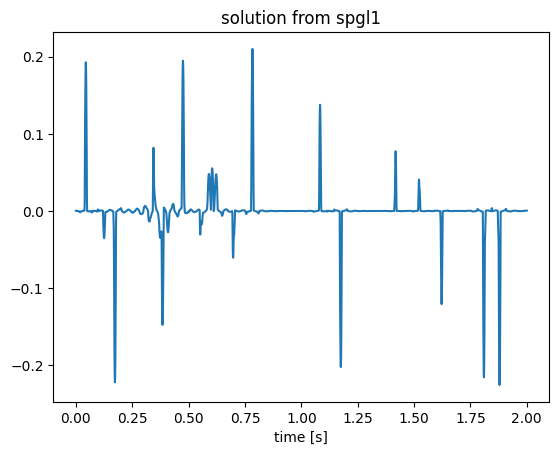

In [10]:
x2, _, _, _ = spgl1(A, b, options = spgOptions(iterations=500, verbosity=0));
figure();plot(t, x2);title("solution from spgl1");xlabel("time [s]");

We can see that spgl1 produces a sparse solution as expected. Notice that we did not provide a matrix to these algorithms, but a linear operator equipped with forward and adjoint evaluations.

## Automatic differentiation (AD) through the linear operator

Furthermore, we have the package [JOLI4Flux](https://github.com/slimgroup/JOLI4Flux.jl) that "teaches" Julia how to differentiate through the linear operator---i.e., "teaches" Julia to apply the adjoint of the linear operator during backpropagation. Taking advantage of this AD capability, we can tryout to solve the inverse problem $Ax=b$ via different regularization techniques and different objective functions. Since the gradient is provided by AD, we can use any kind of gradient-based optimization algorithm to acquire the solution. In the following example, we adopt a least-squares objective with an $\ell_1$ penalty as

$$\min_{x}\frac{1}{2} \|Ax-b\|_2^2 + \lambda \|x\|_1$$

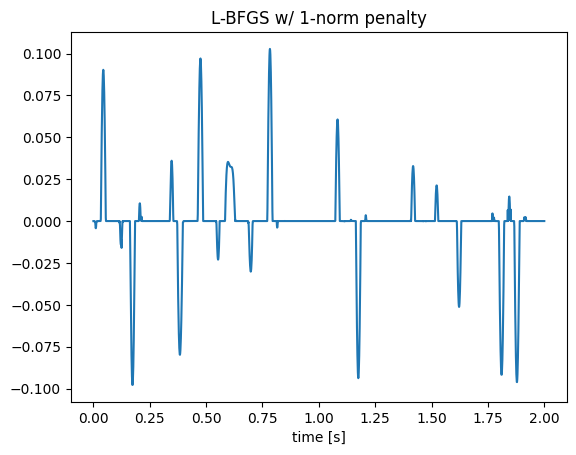

In [11]:
λ = 1;   # weight on l1 regularization
loss(x) = .5 * norm(A * x - b)^2 + λ * norm(x,1);                 # objective function
δloss!(g, x) = begin g.=gradient(loss, x)[1]; return loss(x) end; # in-place gradient function
summary = optimize(loss, δloss!, zeros(N), LBFGS(), Optim.Options(iterations=500));
figure();plot(t, summary.minimizer);title("L-BFGS w/ 1-norm penalty");xlabel("time [s]");

Linear operators in JOLI also talk to deep neural networks in Flux very effectively, we can also reparameterize the input `x` by a network `f` with a fixed input `z` and solve for the network parameters instead---i.e.,

$$\min_{\theta}\|Af_{\theta}(z)-b\|_2^2.$$

This is so-called deep prior approach discussed in Ulyanov, Dmitry, Andrea Vedaldi, and Victor Lempitsky. "Deep image prior." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.

In this tutorial, we adopt a dense layer as a very simple deep prior network for demonstrative purpose only. In practice, the deep prior approach might need careful choices on the network structure and regularization parameters. Thanks to the abstraction, we can still write very clean code to interact with Flux and work with optimizers in Flux, such as ADAM.

In [12]:
f = Dense(2*N, N); # a very simple network
z = randn(2*N);    # fixed input
Flux.trainmode!(f, true);
θ = Flux.params(f);  # network parameters

# Optimizer
opt = ADAM(1f-4)
for j=1:500
    grads = gradient(θ) do
        return .5 * norm(A * f(z) - b)^2 + norm(f(z), 1) + norm(θ)^2;
    end

    # Update params
    for p in θ
        Flux.Optimise.update!(opt, p, grads[p])
    end
end


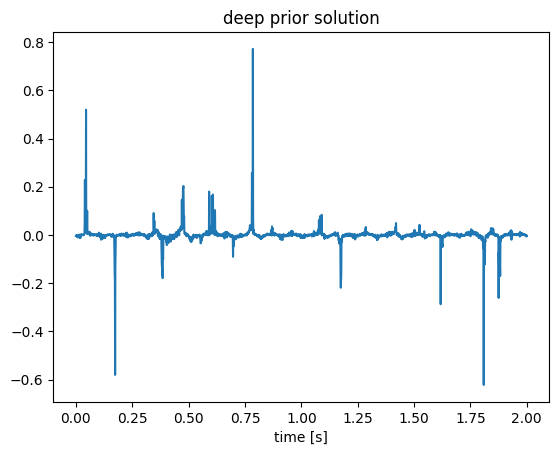

In [13]:
Flux.testmode!(f, true);
figure();plot(t, f(z));title("deep prior solution");xlabel("time [s]");